Los problemas de clasificacion corresponden a un ejemplo de aprendisaje supervizado, donde el vector objetivo responde a un atributo 

Existen muchos fenomenos cuya primera aproximacion e smediante la binarizacion, ¿Existe o no existe una condicion?

Esta aproximacion toma forma en un ensayo de bernoulli.

La biunarizacion corresponde a por ejemplo si van a comprar un ciuerto producto o no, si va votar por cierto candidato o no, hay un excetera de ejemplos y todos corresponden a un problema de calsificacion binario donde se observa la precencia o ausencia de un atributo especifico .

In [2]:
# Importamos la triada clásica
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# seaborn
import seaborn as sns
# scipy stats para simular
import scipy.stats as stats
# statsmodels para modelación
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import lec6_graphs as gfx
plt.style.use('seaborn') # Gráficos estilo seaborn
# plt.rcParams["figure.figsize"] = (6, 3) # Tamaño gráficos
# plt.rcParams["figure.dpi"] = 200 # resolución gráficos
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# ingresamos la base de datos
df = pd.read_csv('datasets/wells.csv')
# La base de datos incluye una columna de índice. Eliminemosla para evitar futuros conflictos
df = df.drop("index", axis = 1)
df.head()

,y,dist100,arsenic,educ4,assoc
0,1,0.16826,2.36,0.0,0
1,1,0.47322,0.71,0.0,0
2,0,0.20967,2.07,2.5,0
3,1,0.21486,1.15,3.0,0
4,1,0.40874,1.10,3.5,1


In [4]:
df.shape

(3020, 5)

In [5]:
df.columns

Index(['y', 'dist100', 'arsenic', 'educ4', 'assoc'], dtype='object')

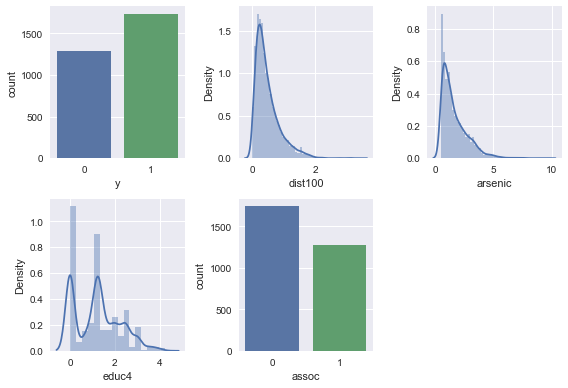

In [6]:
for index, value in enumerate(df):
    plt.subplot(2, 3, index + 1)
    if len(df[value].value_counts()) > 2:
        sns.distplot(df[value])
    else:
        sns.countplot(df[value])
    plt.tight_layout()
    

<AxesSubplot:>

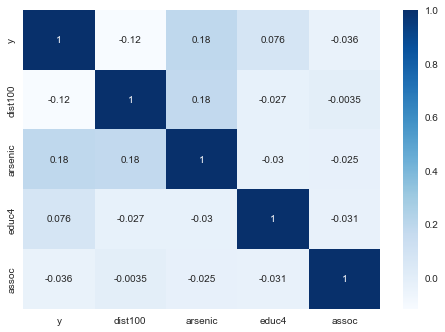

In [7]:
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)

Primera aproximación: utilizar una regrecion lineal asumiendo que nuestra variable dependiente mide la probabilidad del suceso.

Este preoceso se conoce como modelo de probabilidad lineal.

$$Y_i = \beta_0 + \beta_1 \times dist100 + \varepsilon_i$$

La interpretacion de los coeficientes se hace consideracion a la probabilidad de ocurrencia del suceso.

In [8]:
m1_ols = smf.ols('y ~ dist100', df).fit()

In [9]:
def conciense_summary(mod, print_fit = True):
    '''
    Esta funcion genera un resumen abreviado de los principales estadisticos de un modelo.
    Parametros de ingreso: Modelo
    Parametros de salida: Un print
    '''
    fit = pd.DataFrame({'Statistics':mod.summary2().tables[0][0][2:], 
                        'Value':mod.summary2().tables[0][3][2:]})
    estimates = pd.DataFrame(mod.summary2().tables[1].loc[:, 'Coef.':'Std.Err.'])

    if print_fit is True:
        print(f'''
Goodness of Fit statistics 
{fit}''')

    print(f'''
Point estimates
{estimates}''')

In [10]:
conciense_summary(m1_ols)


Goodness of Fit statistics 
          Statistics      Value
2              Date:  4288.4686
3  No. Observations:    -2136.2
4          Df Model:      42.57
5      Df Residuals:   7.95e-11
6         R-squared:    0.24111

Point estimates
              Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225


Para obtener el puntaje Z vamos a dividir el coeficiente del intercepto por el error estandart del intercepto.
0.648407 / 0.014347

45.19460514393253

In [11]:
0.648407/0.014347

45.19460514393253

In [12]:
-0.151539 / 0.023225

-6.5248223896663085

Es superio a lo spuntos criticos por lo que hay evidencia para rechar la hipotecis nula
Ambos estadisticos son una buena aproximacion del modelo

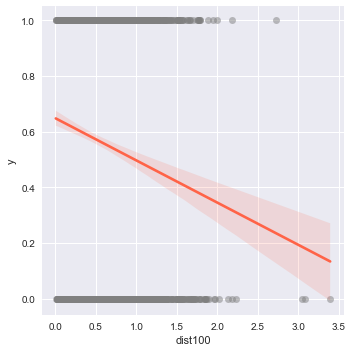

In [13]:
sns.lmplot('dist100', 'y', df, line_kws = {'color':'tomato'}, 
                            scatter_kws = {'color':'grey', 'alpha': .5})

La estimacion de los coeficientes en la regrecion logistica se realiza mediante el metodo de maxima verosimilitud
$$  log \left(\dfrac{Pr(y)}{1 - Pr(y)} \right)= \beta_0 + \beta_1 \times dist100 + \varepsilon_i$$

In [14]:
m1_logit = smf.logit('y ~ dist100', df).fit()
conciense_summary(m1_logit)

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4

Goodness of Fit statistics 
          Statistics       Value
2              Date:   4092.2639
3  No. Observations:     -2038.1
4          Df Model:     -2059.0
5      Df Residuals:  9.7978e-11
6         Converged:      1.0000
7    No. Iterations:            

Point estimates
              Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


>El objetivo es traducir de log-odds a una declaracion probabilistica. Asi generamos una explicacion intituiva sobre el efecto de una variable en la probabilidad de ocurrencia
>
>$$ logit^{-1} (x)= \dfrac{exp(x)}{1 + exp(-x)} $$
>$$	\Downarrow $$
>$$ Pr(Cambio\ de\ pozo = 1 |X) = log \dfrac{exp(\beta_0 + \beta_1)}{1 + exp(\beta_0 + \beta_1)} $$

In [15]:
dist100_mean = df['dist100'].mean()
estimate_y = m1_logit.params['Intercept'] + (m1_logit.params['dist100'] + dist100_mean)
print(estimate_y)

0.4673960540623984


In [16]:
def invlogit(x):
    return 1 / (1 + np.exp(-x))
print(invlogit(estimate_y))


0.6147672524277406


In [17]:
dist100_mean

0.4833186257042435

In [18]:
pr_dist_100 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 1))
pr_dist_200 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 2))
pr_dist_300 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 3))
pr_dist_400 = invlogit(m1_logit.params['Intercept'] + (m1_logit.params['dist100'] * 4))

In [20]:
pr_dist_100, pr_dist_200

(0.4960194411878717, 0.34574300299201427)

In [21]:
print(f'La probabilidad de cambiar entre 100 y 200 es de {round(pr_dist_100 - pr_dist_200, 3)}')

La probabilidad de cambiar entre 100 y 200 es de 0.15


In [22]:
print(f'La probabilidad de cambiar entre 200 y 300 es de {round(pr_dist_200 - pr_dist_300, 3)}')

La probabilidad de cambiar entre 200 y 300 es de 0.125


In [23]:
print(f'La probabilidad de cambiar entre 300 y 400 es de {round(pr_dist_300 - pr_dist_400, 3)}')

La probabilidad de cambiar entre 300 y 400 es de 0.089


In [29]:
decision_boundary = - m1_logit.params['Intercept'] / m1_logit.params['dist100']
decision_boundary

0.97439615007053

(0.0, 0.8)

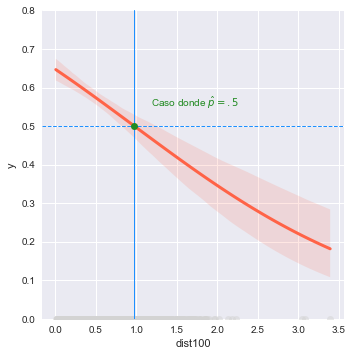

In [31]:
from turtle import color


sns.lmplot('dist100', 'y', df, logistic = True, line_kws={'color':'tomato', 'lw':3},
                                            scatter_kws={'color':'lightgrey', 'alpha':.5})
                                            
plt.axvline(decision_boundary, lw = 1, color = 'dodgerblue')
plt.axhline(.5, linestyle = '--', color = 'dodgerblue', lw = 1)
plt.text(decision_boundary + .2, .5 + .05, r'Caso donde $\hat{p}=.5$', color = 'forestgreen')
plt.plot(decision_boundary, .5, 'o', color = 'forestgreen')
plt.ylim(0.0, 0.8)

In [34]:
print('OLS - LPM')
conciense_summary(m1_ols, print_fit = False)

print('Logit')
conciense_summary(m1_logit, print_fit = False)

OLS - LPM

Point estimates
              Coef.  Std.Err.
Intercept  0.648407  0.014347
dist100   -0.151539  0.023225
Logit

Point estimates
              Coef.  Std.Err.
Intercept  0.605959  0.060310
dist100   -0.621882  0.097426


In [35]:
-0.62 / 4

-0.155